# AutoEncoder

reference: [Learning Internal Representations by Error Propagation](https://stanford.edu/~jlmcc/papers/PDP/Volume%201/Chap8_PDP86.pdf)




## AutoEncoder란?

입력과 출력이 같은 구조. <br>
label이 입력 데이터가 되는 구조로 **unsupervised learning** 방법 중 하나. <br>
정보를 압축하는 encoder 파트와 압축된 정보를 복원하는 decoder 파트로 구성. <br>
중간에는 latent vector가 존재하여 인코더를 통해 압축된 정보를 가지고 있음. <br>

![](https://velog.velcdn.com/images/hyeda/post/cef78295-1a18-43c9-9cb6-90a89a7673cf/image.png)

### Encoder

정보를 압축하기 위한 파트 <br>
입력 데이터를 받아서 이를 낮은 차원의 공간으로 매핑. 이 과정에서 중요한 특징들만 추출하여 잠재 벡터를 생성 <br>
일반적으로는 여러 layer를 stack하여 사용 <br>
layer가 많아질수록 사용하는 nueron의 개수는 줄이는 게 일반적 (undercomplete autoencoder) <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> 입력 데이터의 정보를 압축하기 위함 <br>
Decoder와 대칭 구조를 가짐 <br>

### Latent Vector

bottleneck hiddenlayer, hidden representation, feature 등으로도 불림 <br>
입력 데이터의 중요한 정보가 압축된 형태로 원래 데이터보다 낮은 차원을 가짐. <br>
데이터의 핵심적인 특성을 표현 <br>
이후 디코더에서 사용 <br>

### Decoder

정보를 복원하기 위한 파트 <br>
일반적으로는 여러 layer를 stack하여 사용 <br>
layer가 많아질수록 사용하는 nueron의 개수는 증가하는 게 일반적 <br>
Eecoder와 대칭 구조를 가짐 <br>

## AutoEncoder의 활용

- Dimentionality Reduction
    - latent vector의 dimension을 input dim보다 낮게 설정하여 데이터를 저차원으로 매핑할 수 있음
- Anomaly Detection
    - latent vector를 통하여 정상과 비정상을 구분
- Denosing
    - 원본 이미지에서 정보를 압축했다 다시 복원하는 과정을 통해 불필요한 정보를 제거
- Representation Learning
    - 데이터의 주요 특징을 포착하여 벡터화
- Manifold Learning
    - 고차원 공간의 데이터를 가장 잘 표현할 수 있는 저차원 공간에 매핑

### 사용 방법

> ```python
> import torch.nn as nn
> 
> class Autoencoder(nn.Module):
>     def __init__(self, latent_dim):
>         self.latent_dim = latent_dim
>         super().__init__()
>         # 인코더
>         self.encoder = nn.Sequential(
>             nn.Linear(784, 128),            # 입력층
>             nn.ReLU(),
>             nn.Linear(128, 64),             # 중간층
>             nn.ReLU(),
>             nn.Linear(64, latent_dim)       # 잠재 벡터
>         )
>         # 디코더
>         self.decoder = nn.Sequential(
>             nn.Linear(latent_dim, 64),      # 잠재 벡터 입력
>             nn.ReLU(),
>             nn.Linear(64, 128),             # 중간층
>             nn.ReLU(),
>             nn.Linear(128, 784),            # 출력층
>         )
> 
>     def forward(self, x):
>         latent_vector = self.encoder(x)
>         x_reconstructed = self.decoder(latent_vector)
>         
>         return x_reconstructed
> ```

# Practice

In [159]:
from src.data import MNISTDataset, MNISTDataModule
from src.training import MNISTModule
from src.model.auto_encoder import Encoder, Decoder, AutoEncoder

import pandas as pd
import json
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import plotly.express as px

## Implementation

### Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim,
        latent_dim,
        dropout_ratio: float = 0.5,
        ):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_ratio = dropout_ratio  # 드롭아웃 비율 설정

        # 인코더의 여러 층 정의
        self.linear1 = nn.Linear(self.input_dim, 500)  # 입력을 500 차원으로 변환
        self.batch_norm1 = nn.BatchNorm1d(500)  # 첫 번째 층의 배치 정규화
        self.leaky_relu1 = nn.LeakyReLU()  # 첫 번째 활성화 함수
        self.dropout1 = nn.Dropout(self.dropout_ratio)  # 첫 번째 드롭아웃

        self.linear2 = nn.Linear(500, 300)  # 500 차원에서 300 차원으로 변환
        self.batch_norm2 = nn.BatchNorm1d(300)  # 두 번째 층의 배치 정규화
        self.leaky_relu2 = nn.LeakyReLU()  # 두 번째 활성화 함수
        self.dropout2 = nn.Dropout(self.dropout_ratio)  # 두 번째 드롭아웃

        self.output = nn.Linear(300, self.latent_dim)  # 최종 출력 차원 설정
    
    def forward(self, x):
        # 입력 데이터를 인코딩하기 위한 순전파 과정
        x = self.linear1(x)  # 첫 번째 선형 변환
        x = self.batch_norm1(x)  # 정규화
        x = self.leaky_relu1(x)  # 활성화
        x = self.dropout1(x)  # 드롭아웃 적용

        x = self.linear2(x)  # 두 번째 선형 변환
        x = self.batch_norm2(x)  # 정규화
        x = self.leaky_relu2(x)  # 활성화
        x = self.dropout2(x)  # 드롭아웃 적용

        x = self.output(x)  # 최종 인코딩된 결과 생성

        return x  # 인코딩된 결과 반환


In [12]:
encoder = Encoder(784, 2)
encoder

Encoder(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (batch_norm1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=500, out_features=300, bias=True)
  (batch_norm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=300, out_features=2, bias=True)
)

In [13]:
x = torch.randn(32, 28*28)  # batch_size, dim
latent_vector = encoder(x)  # batch_size, 2
latent_vector.shape

torch.Size([32, 2])

In [20]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim,
        latent_dim,
        dropout_ratio: float = 0.5):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_ratio = dropout_ratio  # 드롭아웃 비율 설정

        # nn.Sequential을 통한 구조화
        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, 500),  # 선형 변환
            nn.BatchNorm1d(500),  # 배치 정규화
            nn.LeakyReLU(),  # 활성화 함수
            nn.Dropout(self.dropout_ratio),  # 드롭아웃
        )

        # nn.Sequential을 통한 구조화
        self.layer2 = nn.Sequential(
            nn.Linear(500, 300),  # 선형 변환
            nn.BatchNorm1d(300),  # 배치 정규화
            nn.LeakyReLU(),  # 활성화 함수
            nn.Dropout(self.dropout_ratio),  # 드롭아웃
        )

        self.output = nn.Linear(300, self.input_dim)  # 최종 출력 차원 설정 (원래 입력 차원)

    def forward(self, x):
        # 입력 데이터를 통해 순전파
        x = self.layer1(x)  # 첫 번째 레이어 통과
        x = self.layer2(x)  # 두 번째 레이어 통과
        x = self.output(x)  # 최종 출력 생성

        return x  # 인코딩된 결과 반환


In [17]:
encoder = Encoder(784, 2)
encoder

Encoder(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=300, out_features=2, bias=True)
)

In [18]:
x = torch.randn(32, 28*28)  # batch_size, dim
latent_vector = encoder(x)  # batch_size, 2
latent_vector.shape

torch.Size([32, 2])

### Decoder

In [23]:
class Decoder(nn.Module):
    def __init__(
        self,
        input_dim,
        latent_dim,
        dropout_ratio: float = 0.5,
        ):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_ratio = dropout_ratio  # 드롭아웃 비율 설정

        # nn.Sequential을 통한 구조화
        self.layer1 = nn.Sequential(
            nn.Linear(self.latent_dim, 300),  # 선형 변환
            nn.BatchNorm1d(300),  # 배치 정규화
            nn.LeakyReLU(),  # 활성화 함수
            nn.Dropout(self.dropout_ratio),  # 드롭아웃
        )

        # nn.Sequential을 통한 구조화
        self.layer2 = nn.Sequential(
            nn.Linear(300, 500),  # 선형 변환
            nn.BatchNorm1d(500),  # 배치 정규화
            nn.LeakyReLU(),  # 활성화 함수
            nn.Dropout(self.dropout_ratio),  # 드롭아웃
        )

        self.output = nn.Linear(500, self.input_dim)  # 최종 출력 차원 설정 (원래 입력 차원)

    def forward(self, x):
        # 입력 데이터를 통해 순전파
        x = self.layer1(x)  # 첫 번째 레이어 통과
        x = self.layer2(x)  # 두 번째 레이어 통과
        x = self.output(x)  # 최종 출력 생성

        return x  # 복원된 결과 반환


In [ ]:
decoder = Decoder(28*28, 2)
decoder

In [26]:
decoder(latent_vector).shape

torch.Size([32, 784])

### AutoEncoer

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder  # 인코더 모듈 저장
        self.decoder = decoder  # 디코더 모듈 저장
    
    def forward(self, x):
        # 입력 데이터를 인코딩하고 복원하는 과정
        latent_vector = self.encoder(x)  # 인코딩된 잠재 벡터 생성
        x_reconstructed = self.decoder(latent_vector)  # 잠재 벡터를 통해 원본 데이터 복원

        return x_reconstructed, latent_vector  # 복원된 데이터와 잠재 벡터 반환


In [33]:
# AutoEncoder 인스턴스 생성: 인코더와 디코더 모듈을 포함
auto_encoder = AutoEncoder(encoder, decoder)

# 입력 데이터 x를 통해 복원된 데이터와 잠재 벡터 생성
x_reconstructed, latent_vector = auto_encoder(x)


### Loss

In [36]:
# 복원된 데이터와 원본 데이터 간의 MSE 손실 계산
loss = F.mse_loss(x_reconstructed, x)

tensor(1.3121, grad_fn=<MseLossBackward0>)

## Recunstruction

### Load Checkpoint

In [48]:
# hyperparameter
with open('./configs.json', 'r') as file:
    configs = json.load(file)

In [81]:
# 'MNIST' 데이터셋을 로드 and preprocessing
train = ds.MNIST(
    root='data/mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

test = ds.MNIST(
    root='data/mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

# 데이터셋을 학습용과 검증 데이터로 분할
train, valid = train_test_split(
    train,
    test_size=0.2,
    random_state=configs.get('seed'),
)

# 데이터셋 객체로 변환
train_dataset = MNISTDataset(train)
valid_dataset = MNISTDataset(valid)
test_dataset = MNISTDataset(test)

# 데이터 모듈 생성 및 데이터 준비
mnist_data_module = MNISTDataModule(batch_size=configs.get('batch_size'))
mnist_data_module.prepare(train_dataset, valid_dataset, test_dataset)


In [54]:
# 설정(configs) 업데이트: 입력 차원 계산
configs.update({
    'input_dim': train[0][0].shape[1] * train[0][0].shape[2],  # 입력 데이터의 차원 수 계산
})

# 인코더와 디코더 인스턴스 생성: 잠재 차원은 2로 설정
encoder = Encoder(configs.get('input_dim'), 2)
decoder = Decoder(configs.get('input_dim'), 2)

# AutoEncoder 모델 생성
model = AutoEncoder(encoder, decoder)

# LightningModule 인스턴스 생성: 모델과 학습률 설정
mnist_module = MNISTModule(
    model=model,
    learning_rate=configs.get('learning_rate'),  # 설정에서 학습률 가져오기
)

In [74]:
# 체크포인트에서 MNISTModule 모델 로드: 저장된 가중치와 설정 가져오기
model = MNISTModule.load_from_checkpoint(
    r'C:\Users\USER\Documents\git\2024-08-05_Encore\day33\tensorboard\MNIST\batch_size=256,learning_rate=0.004,dropout_ratio=0.3,device=cpu,input_dim=784\version_3\checkpoints\epoch=54-step=10340.ckpt',
    model=model,  # 이전에 정의한 모델을 사용
    learning_rate=configs.get('learning_rate'),  # 설정에서 학습률 가져오기
)

# 모델을 평가 모드로 전환: 드롭아웃 등 비활성화
model.eval()

In [141]:
# DataLoader 인스턴스 생성: 학습 데이터셋을 배치 단위로 로드
train_dataloader = DataLoader(
    train_dataset,
    batch_size=configs.get('batch_size'),  # 설정에서 배치 크기 가져오기
)

latent_vectors = []  # 잠재 벡터 저장 리스트
labels = []  # 레이블 저장 리스트

# 학습 데이터 로드 및 처리
for train_dataloader_ in train_dataloader:
    # 입력 데이터를 모델에 통과시켜 복원된 데이터와 잠재 벡터 생성
    x_reconstructed, latent_vector = model.model(
        train_dataloader_.get('X').flatten(start_dim=1)  # 입력 데이터를 평탄화
    )
    latent_vectors.append(latent_vector)  # 잠재 벡터 추가
    labels.append(train_dataloader_.get('y').detach())  # 레이블 추가 (기타 연산 방지)

In [142]:
# 저장된 잠재 벡터와 레이블 리스트를 텐서로 결합
latent_vectors = torch.cat(latent_vectors)  # 모든 잠재 벡터를 하나의 텐서로 결합
labels = torch.cat(labels)  # 모든 레이블을 하나의 텐서로 결합


In [139]:
# 잠재 벡터를 데이터프레임으로 변환: 각 차원을 별도의 열로 저장
result = pd.DataFrame(latent_vectors.detach(), columns=['ae1', 'ae2'])
result['label'] = labels  # 레이블 추가
result.label = result.label.astype(str)  # 레이블을 문자열 형식으로 변환

# 산점도 플롯 생성: 잠재 벡터의 두 차원을 시각화
px.scatter(
    result,
    x='ae1',  # x축: 첫 번째 잠재 차원
    y='ae2',  # y축: 두 번째 잠재 차원
    color='label',  # 색상: 레이블에 따라 구분
)

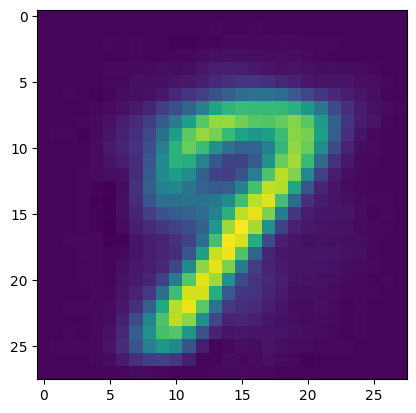

In [154]:
# 복원된 데이터 중 세 번째 이미지를 2D 형태로 변환하여 시각화
plt.imshow(x_reconstructed[2].reshape(28, -1).detach())

### modeling

In [161]:
# 결과 데이터셋을 학습용과 테스트용으로 분할: 80%는 학습, 20%는 테스트
train, test = train_test_split(result, test_size=0.2)

# LightGBM 분류기 인스턴스 생성 및 학습: 레이블을 예측하기 위해 학습 데이터에 적합
model = LGBMClassifier(verbose=0).fit(train.drop(columns='label'), train.label)

In [165]:
# 테스트 데이터에 대한 예측 정확도 계산: 예측값과 실제 레이블 비교
accuracy = (model.predict(test.drop(columns=['label'])) == test.label).mean()  # 정확도의 평균 계산

0.719375

## Anomaly Detection

In [ ]:
# 설정(configs) 업데이트: 입력 차원 계산
configs.update({
    'input_dim': 28 * 28,  # MNIST 이미지의 픽셀 수 (28x28)
})

# 인코더와 디코더 인스턴스 생성: 잠재 차원은 5로 설정
encoder = Encoder(configs.get('input_dim'), 5)
decoder = Decoder(configs.get('input_dim'), 5)

# AutoEncoder 모델 생성
model = AutoEncoder(encoder, decoder)

# LightningModule 인스턴스 생성: 모델과 학습률 설정
mnist_module = MNISTModule(
    model=model,
    learning_rate=configs.get('learning_rate'),  # 설정에서 학습률 가져오기
)

# 체크포인트에서 MNISTModule 모델 로드: 저장된 가중치와 설정 가져오기
model = MNISTModule.load_from_checkpoint(
    r'C:\Users\USER\Documents\git\2024-08-05_Encore\day33\tensorboard\MNIST\batch_size=256,learning_rate=0.004,dropout_ratio=0.3,device=cpu,input_dim=784\version_5\checkpoints\epoch=90-step=1911.ckpt',
    model=model,  # 이전에 정의한 모델을 사용
    learning_rate=configs.get('learning_rate'),  # 설정에서 학습률 가져오기
)

# 모델을 평가 모드로 전환: 드롭아웃 등 비활성화
model.eval()

In [172]:
# DataLoader 인스턴스 생성: 학습 데이터셋을 배치 단위로 로드
train_dataloader = DataLoader(
    train_dataset,
    batch_size=configs.get('batch_size'),  # 설정에서 배치 크기 가져오기
)

latent_vectors = []  # 잠재 벡터 저장 리스트
labels = []  # 레이블 저장 리스트

# 학습 데이터 로드 및 처리
for train_dataloader_ in train_dataloader:
    # 입력 데이터를 모델에 통과시켜 복원된 데이터와 잠재 벡터 생성
    x_reconstructed, latent_vector = model.model(
        train_dataloader_.get('X').flatten(start_dim=1)  # 입력 데이터를 평탄화하여 모델에 입력
    )
    latent_vectors.append(latent_vector)  # 잠재 벡터 추가
    labels.append(train_dataloader_.get('y').detach())  # 레이블 추가 (기타 연산 방지)

label: 7
loss: 52.21699523925781


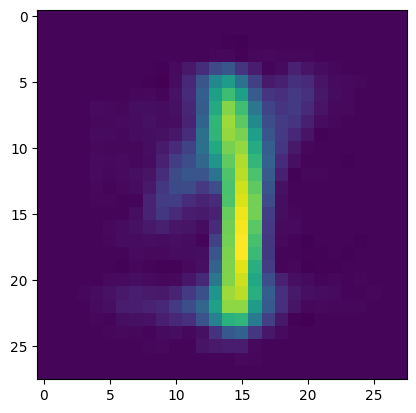

In [220]:
idx = 16  # 확인할 인덱스 설정

# 인덱스에 해당하는 레이블 출력
print(f"label: {train_dataloader_.get('y')[idx]}")

# 원본 이미지와 복원된 이미지 가져오기
original = train_dataloader_.get('X')[idx][0]  # 원본 이미지
reconstructed = x_reconstructed[idx].reshape(28, -1).detach()  # 복원된 이미지를 2D 형태로 변환

# 원본 이미지와 복원된 이미지 간의 손실 계산
loss = ((original - reconstructed) ** 2).sum()  # 손실 계산 (제곱 오차의 합)
print(f'loss: {loss}')  # 손실 출력

# plt.imshow(train_dataloader_.get('X')[0][idx])  # 원본 이미지 표시 (주석 처리됨)
plt.imshow(x_reconstructed[idx].reshape(28, -1).detach())  # 복원된 이미지 표시

In [232]:
losses = []  # 손실을 저장할 리스트
labels = []  # 레이블을 저장할 리스트

# 첫 128개의 샘플에 대해 손실과 레이블 계산
for idx in range(128):    
    original = train_dataloader_.get('X')[idx][0]  # 원본 이미지 가져오기
    label = train_dataloader_.get('y')[idx]  # 해당 레이블 가져오기

    # 복원된 이미지를 2D 형태로 변환
    reconstructed = x_reconstructed[idx].reshape(28, -1).detach()  
    loss = ((original - reconstructed) ** 2).sum()  # 손실 계산 (제곱 오차의 합)
    
    losses.append(loss.item())  # 손실 값을 리스트에 추가
    labels.append(label.item())  # 레이블 값을 리스트에 추가

In [240]:
# 손실이 10보다 작은 경우 0, 그렇지 않은 경우 1로 변환하여 이진 배열 생성
# 레이블이 1인 경우 0, 그렇지 않은 경우 1로 변환하여 이진 배열 생성
(np.where(np.array(losses) < 10, 0, 1) == np.where(np.array(labels) == 1, 0, 1)).mean()  # 두 배열의 일치 비율 계산

0.9921875